# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering` and `DBSCAN`
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
X_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
delimiter = ','
X0 = pd.read_csv(X_url, delimiter=delimiter)
X0.shape

(440, 8)

In [3]:
X0.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Observe the data distributions

<Axes: >

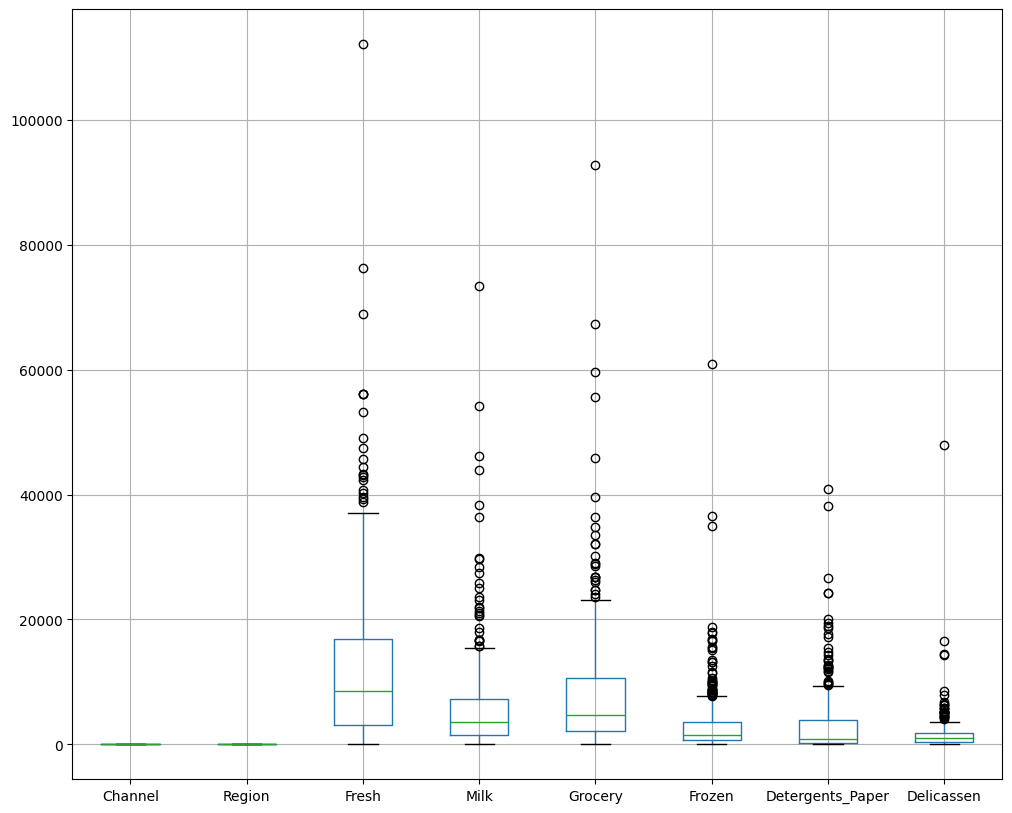

In [4]:
X0.boxplot(figsize=(12,10))

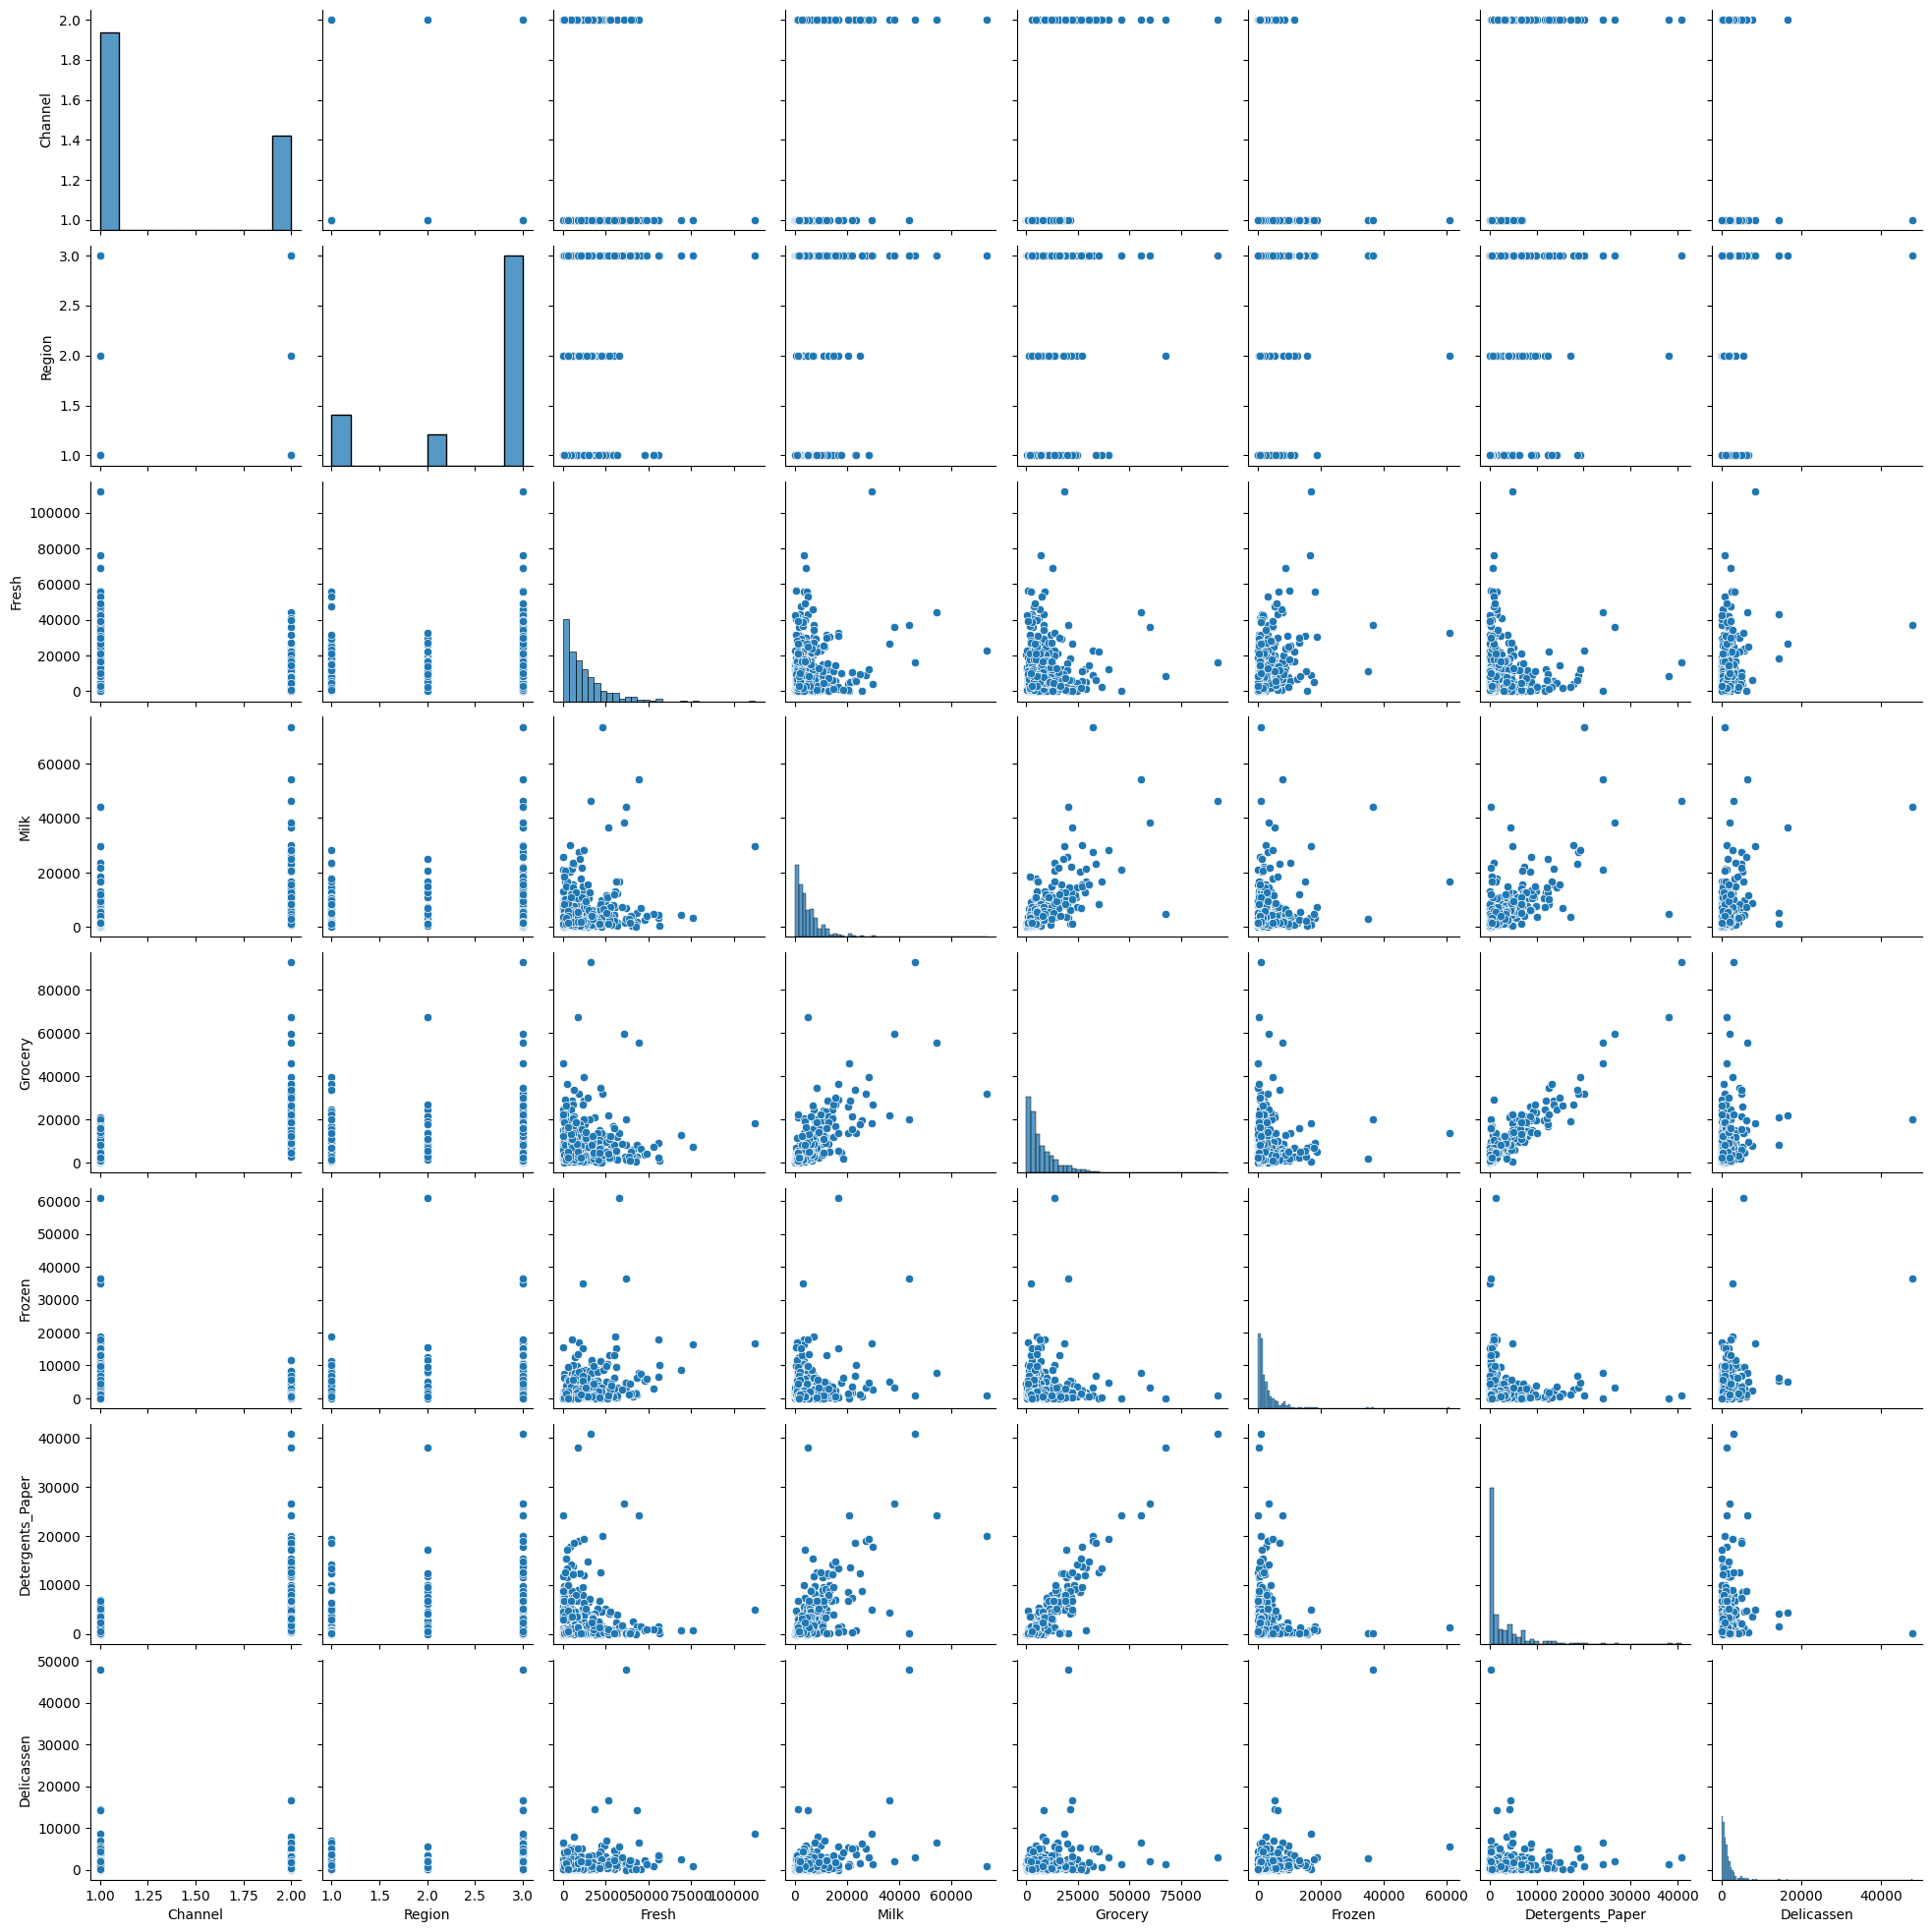

In [5]:
import seaborn as sns
sns.pairplot(X0)
plt.show()

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1`

In [6]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

# gaussian like 
pt = PowerTransformer()
pt.fit(X0)
X = pt.transform(X0) # gaussian-like distribution, return an array 
X = pd.DataFrame(X) 

# range in (0,1)
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X) # similar ranges between different columns  
X = pd.DataFrame(X, columns = X0.columns)
X.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.501828,0.667606,0.625238,0.208640,0.649941,0.412016
1,1.0,1.0,0.414266,0.670028,0.655690,0.458800,0.674852,0.445663
2,1.0,1.0,0.400077,0.653586,0.627297,0.499856,0.682752,0.654292
3,0.0,1.0,0.509368,0.369264,0.553550,0.636716,0.461095,0.446485
4,1.0,1.0,0.604755,0.580657,0.618985,0.566470,0.601884,0.590255


Show the result of the transformation

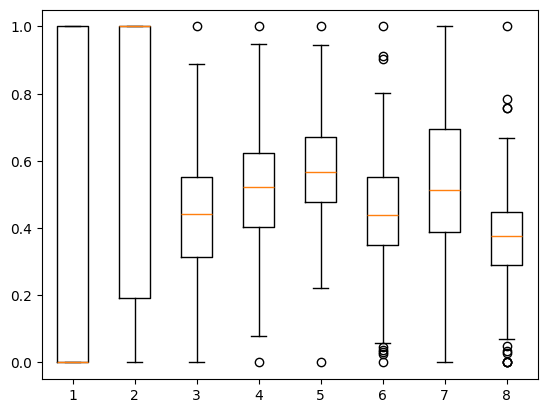

In [7]:
plt.boxplot(X)
plt.show()

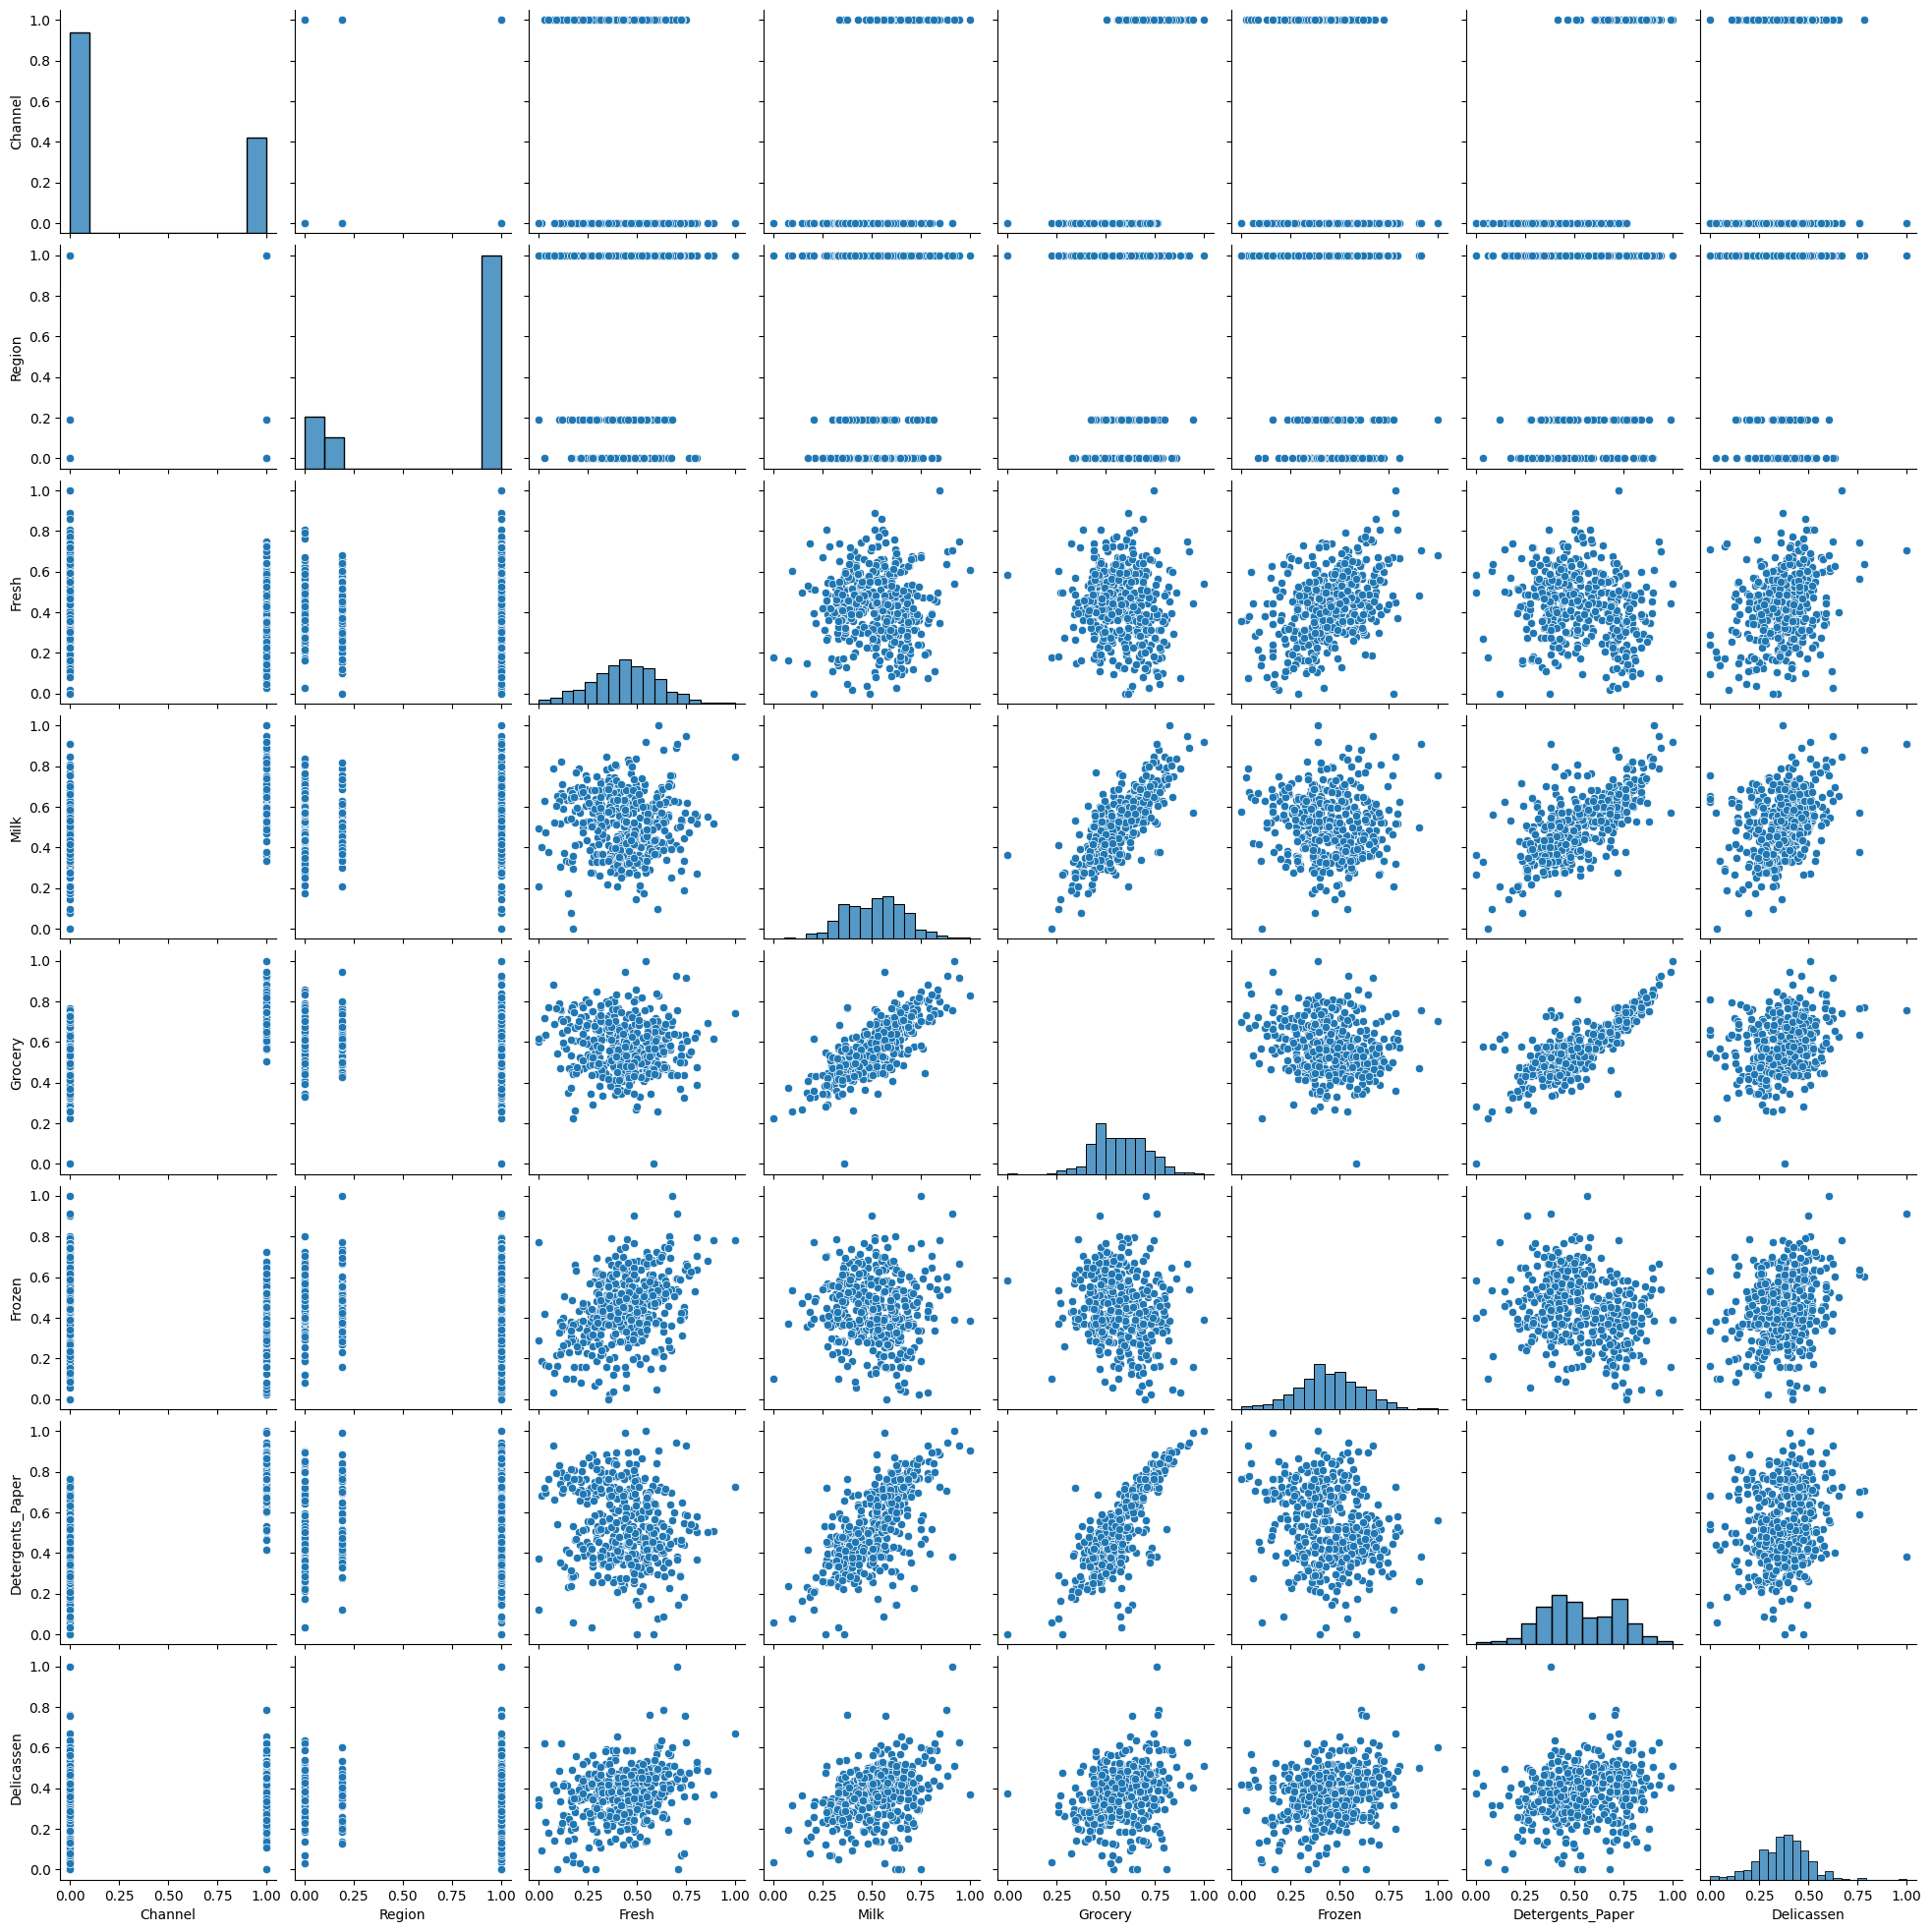

In [8]:
sns.pairplot(X)
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [9]:
from sklearn.metrics import silhouette_score

kmin, kmax = 2, 10 # number of clusters 
res = []

for k in range(kmin,kmax + 1):
    
    # perform the kmeans 
    estimator = KMeans(n_clusters=k, random_state=random_state) # make k cluster 
    estimator.fit(X)
    X_pred = estimator.predict(X)
    
    # compute and store the accuracy metrics 
    couple = (estimator.inertia_, silhouette_score(X, X_pred))
    res.append(couple)

## 4. Plot __inertia__ and __silhouette score__ versus `k`

In [10]:
inertia = []
silscore = []

for couple in res:
    
    # store the metrics separatedly
    inertia.append(couple[0])
    silscore.append(couple[1])

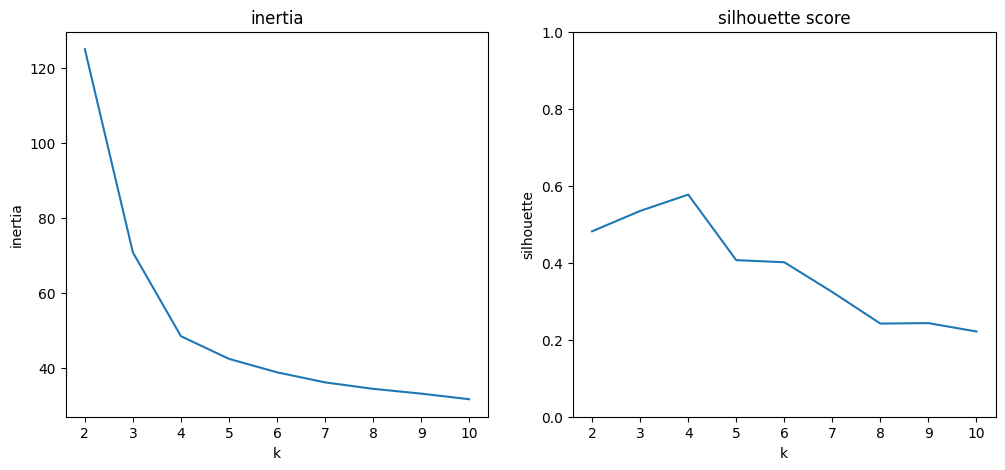

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.title('inertia')
plt.plot(range(kmin, kmax+1), inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.subplot(1, 2, 2)
plt.plot(range(kmin, kmax+1), silscore)
plt.title('silhouette score')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.ylim(0, 1)
plt.show()

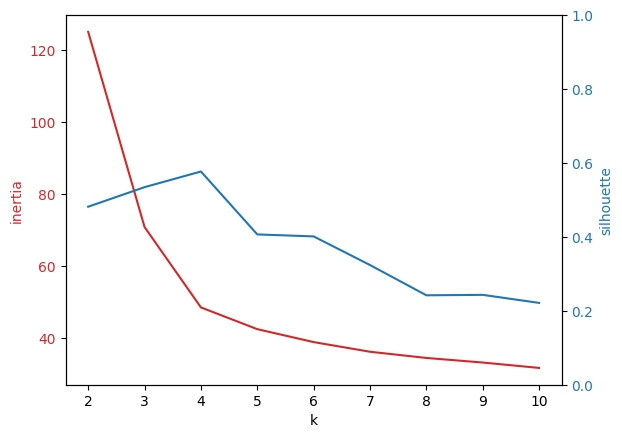

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('inertia', color=color)
ax1.plot(range(2,11), inertia, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(range(2,11), silscore, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)

plt.show()

## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=4

In [13]:
# prof results 
k = 4
print(f"Number of clusters = {k}	- Distortion = {inertia[k - 2]}	   - Silhouette score = {silscore[k - 2]}")

Number of clusters = 4	- Distortion = 48.47307162387674	   - Silhouette score = 0.5769101944616627


Show the distribution of samples in the clusters with a pie chart

In [14]:
estimator = KMeans(n_clusters=k, random_state=random_state)
estimator.fit(X)
y_pred = estimator.predict(X)

In [15]:
dd = np.unique(y_pred, return_counts=True)

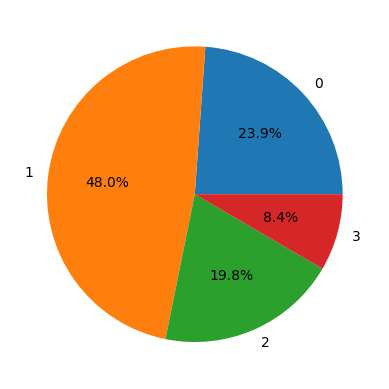

In [16]:
plt.pie(x = dd[1], labels = dd[0], autopct='%1.1f%%')
plt.show()

In [17]:
cl0 = 0
cl1 = 0
cl2 = 0
cl3 = 0

estimator = KMeans(n_clusters=4, random_state=random_state)
estimator.fit(X)
X_pred = estimator.predict(X)

for k in X_pred:
    if k == 0:
        cl0+=1 
    if k == 1:
        cl1+=1 
    if k == 2:
        cl2+=1 
    if k == 3:
        cl3+=1 
        
n_samples = X.shape[0]
cl0 /= n_samples
cl1 /= n_samples
cl2 /= n_samples
cl3 /= n_samples

print(cl0)
print(cl1)
print(cl2)
print(cl3)

0.23863636363636365
0.47954545454545455
0.19772727272727272
0.08409090909090909


### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Agglomerative clustering
We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

In [18]:
from sklearn.cluster import AgglomerativeClustering

In [19]:
table = pd.DataFrame(columns = ['linkage', 'n_clusters', 'silhouette_score'])
for k in range(kmin,kmax + 1):
    for linkage in ['ward', 'complete', 'average', 'single']:
        cluster = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        pred = cluster.fit_predict(X)
        table.loc[len(table)] = [linkage, k, silhouette_score(X,pred)]
        
table

,linkage,n_clusters,silhouette_score
0,ward,2,0.481596
1,complete,2,0.481596
2,average,2,0.481596
3,single,2,0.481596
4,ward,3,0.534541
5,complete,3,0.530266
6,average,3,0.534541
7,single,3,0.534541
8,ward,4,0.576910
9,complete,4,0.505916


The top five results have a very similar silhouette score, we will choose the setting with 4 clusters, as for k-means, and the linkage giving the best result with 4 clusters, that is `ward`. This is the result record with `index 2` (the record index is the unnamed column at the very left of the dataframe output

In [20]:
# sort pdtable in ascending order respect to the silhouette score 
table.sort_values(by = 'silhouette_score', ascending=False, inplace = True)

In [21]:
table.head()

,linkage,n_clusters,silhouette_score
8,ward,4,0.576910
10,average,4,0.576910
11,single,4,0.576910
15,single,5,0.553523
13,complete,5,0.549272


Show the distribution of data in the clusters

In [22]:
best_row = table.iloc[0,:] # select the first line 
print(best_row)

linkage                ward
n_clusters                4
silhouette_score    0.57691
Name: 8, dtype: object


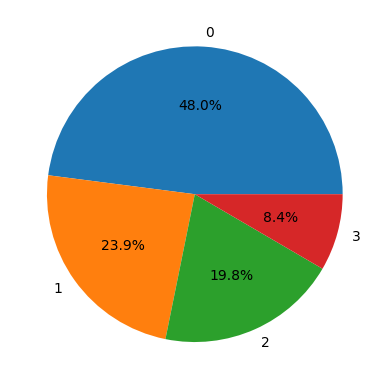

In [23]:
estimator = AgglomerativeClustering(n_clusters=4, linkage='ward')
estimator.fit(X)
y_pred = estimator.fit_predict(X)

dd = np.unique(y_pred, return_counts=True)
plt.pie(x = dd[1], labels = dd[0], autopct = '%1.1f%%')
plt.show()

In [24]:
cl0 = 0
cl1 = 0
cl2 = 0
cl3 = 0

estimator = AgglomerativeClustering(n_clusters=4, linkage='ward')
estimator.fit(X)
X_pred = estimator.fit_predict(X)

for k in X_pred:
    if k == 0:
        cl0+=1 
    if k == 1:
        cl1+=1 
    if k == 2:
        cl2+=1 
    if k == 3:
        cl3+=1 
        
n_samples = X.shape[0]
cl0 /= n_samples
cl1 /= n_samples
cl2 /= n_samples
cl3 /= n_samples

print(cl0)
print(cl1)
print(cl2)
print(cl3)

0.47954545454545455
0.23863636363636365
0.19772727272727272
0.08409090909090909


### Comments


The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the smaller the numbers out of the main diagona, the better the match.

For easier readability, we divide all the elements of the matrix by the sum of all the elements of the matrix, in this way, the matrix elements are normalized to 1.

In [25]:
from sklearn.metrics import pair_confusion_matrix

# perform best Kmeans
estimator = KMeans(n_clusters=4, random_state=random_state)
estimator.fit(X)
pred_kmeans = estimator.predict(X)

# perform best AgglomearativeClustering
estimator = AgglomerativeClustering(n_clusters=4, linkage='ward')
estimator.fit(X)
pred_agglomerative = estimator.fit_predict(X)

# pair confusion matrix 
cm = pair_confusion_matrix(pred_kmeans, pred_agglomerative)
cm = cm / (cm[0][0] + cm[1][1])
print(cm)

[[0.66844067 0.        ]
 [0.         0.33155933]]


A short indicator of the match percentage can be optained as a sum of the elements of the main diagonal.

In [26]:
print(f"The percentage of match between the two clustering schemes is  {100 * (cm[0][0] + cm[1][1])} %")

The percentage of match between the two clustering schemes is  100.0 %


## DBSCAN

In [28]:
from sklearn.cluster import DBSCAN
db = DBSCAN()
ypred_db = db.fit_predict(X)

In [29]:
print(f"default parameters are eps = {db.eps} and min_samples = {db.min_samples}")

default parameters are eps = 0.5 and min_samples = 5


Show the distribution of data in the clusters

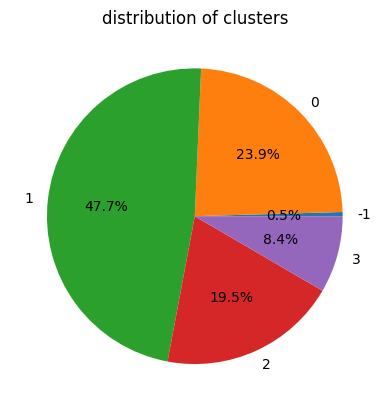

In [37]:
dd = np.unique(ypred_db, return_counts = True)
plt.pie(x = dd[1], labels = dd[0], autopct = '%1.1f%%')
plt.title(f"distribution of clusters")
plt.show()

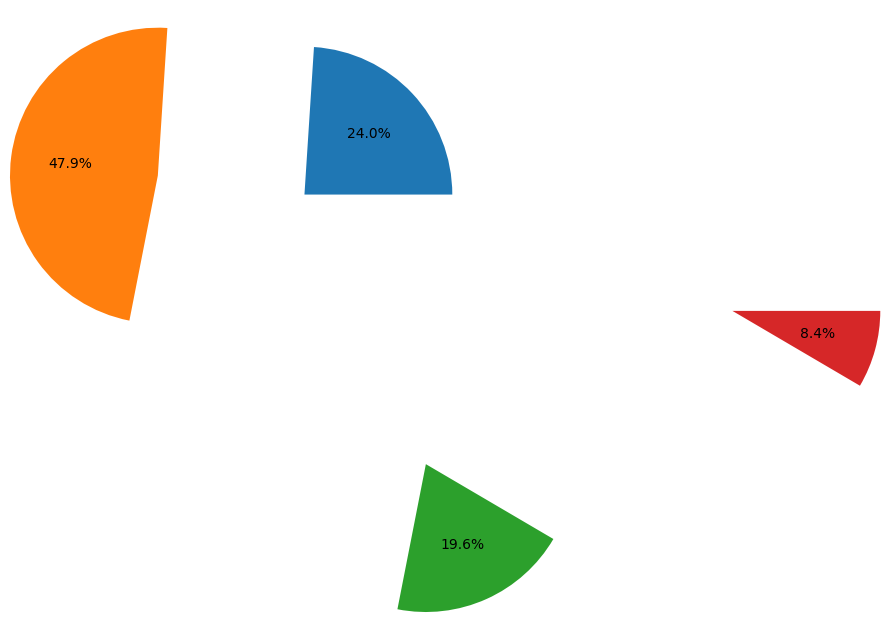

In [39]:
dd = np.unique(ypred_db[ypred_db != -1], return_counts = True)
plt.pie(dd[1], dd[0], autopct = '%1.1f%%')
plt.show()

In [45]:
import seaborn as sns
pred = pd.DataFrame({'ypred_db':ypred_db})
pred.shape[0] == X.shape[0]
X = pd.concat([X, pred], axis = 1)
sns.pairplot(X, hue = 'ypred_db')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### 5. Find the best parameters using `ParameterGrid`

prepare the dictionary of the parameter ranges and produce the list of parameter settings to test with the function `ParameterGrid`

In [47]:
from sklearn.model_selection import ParameterGrid

param = {
    'eps':list(np.arange(0.001, 1, 0.005)), 
    'min_samples':[*range(2, 10, 1)]
    }

param_grid = list(ParameterGrid(param))

results = pd.DataFrame(columns = ['eps', 'min_samples', 'n_clusters', 'silhouette', 'pct_unclust'])
for params in param_grid:
    db = DBSCAN(**(params)) # set the parameters for Dbscan
    ypred = db.fit_predict(X) # make prediction 
    clusters_labels_all = np.unique(ypred) # all clusters 
    clusters_labels = clusters_labels_all[clusters_labels_all != -1] # all effective clusters 
    n_clusters = len(clusters_labels) # number of effective clusters 
    
    if 1 < n_clusters and n_clusters < len(ypred):
        Xcl = X.iloc[ypred != -1,:] # effective clusters in X 
        ypredcl = ypred[ypred != -1] # effective clusters labels 
        sil = silhouette_score(Xcl, ypredcl) # silhouette score
        pct_unclast = (1 - ypredcl.shape[0]/ypred.shape[0]) * 100 #percentage of unclasted samples 
        results.loc[len(results)] = [db.eps, db.min_samples, n_clusters, sil, pct_unclast] # update the results table 

In [93]:
# visualize only results above some tresholds 
sil_tr = 0.5
uncl_tr = 10
n_clust_max_tr = 5

results[(results['silhouette'] >= sil_tr)\
    & (results['pct_unclust'] <= uncl_tr)\
    & (results['n_clusters'] <= n_clust_max_tr)]

,eps,min_samples,n_clusters,silhouette,pct_unclust
245,0.251,3.0,5.0,0.554624,9.318182
253,0.256,3.0,5.0,0.545802,7.954545
254,0.256,4.0,5.0,0.547461,8.409091
261,0.261,3.0,5.0,0.545723,7.727273
262,0.261,4.0,5.0,0.546681,7.954545
...,...,...,...,...,...
1143,0.811,5.0,3.0,0.534541,0.000000
1144,0.811,6.0,3.0,0.534541,0.000000
1145,0.811,7.0,3.0,0.534541,0.000000
1146,0.811,8.0,3.0,0.534541,0.000000


In [95]:
results[results['n_clusters'] == 4].sort_values(by = ['silhouette', 'pct_unclust'], ascending = False)

,eps,min_samples,n_clusters,silhouette,pct_unclust
0,0.051,2.0,4.0,0.810283,98.181818
120,0.171,6.0,4.0,0.646802,49.545455
111,0.166,5.0,4.0,0.646224,50.681818
128,0.176,6.0,4.0,0.640604,46.363636
119,0.171,5.0,4.0,0.637156,46.590909
...,...,...,...,...,...
19,0.101,5.0,4.0,0.400643,95.454545
72,0.141,6.0,4.0,0.397130,71.818182
98,0.156,8.0,4.0,0.382141,69.318182
106,0.161,8.0,4.0,0.353064,67.045455


Arrange DBSCAN results in a dataframe, for easier presentation and filtering

`dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])`

- for each parameter setting

### 6. Observe  
- Observe visually the most promising combination of parameters reproducing the same number of clusters of the previous experiments 
- fit and predict the cluster labels and show a pairplot

In [ ]:
# reproduce the best dbscan clustering
eps = 0.051
min_samples = 2
dbbest = DBSCAN(min_samples = min_samples, eps = eps)
ypred = dbbest.fit_predict(X)

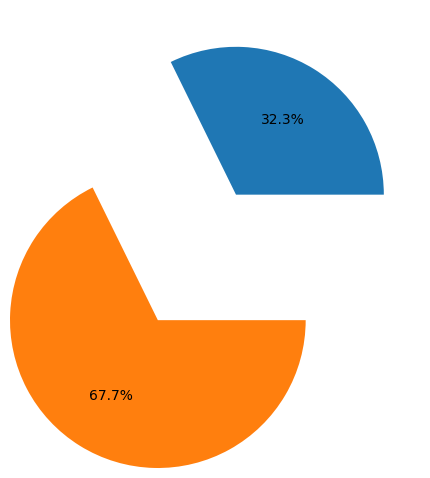

In [96]:
dd = np.unique(ypred[ypred != -1], return_counts = True)
plt.pie(dd[1], dd[0], autopct = '%1.1f%%')
plt.show()

Show the cluster sizes

## Silhouette plots

Use the function `plot_silhouette` contained in the module `plot_silhouette_w_mean` (provided with the notebook) and from `sklearn.metrics` import the function `silhouette_samples` providing the silhouette score for each sample

`from plot_silhouette_w_mean import plot_silhouette  # python script provided separately`

Hint: use `help(plot_silhouette)` for the meaning of the parameters

Hint: for DBSCAN you should exclude the rows of noise

In [30]:
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately


## Optional - Comparison with __boxplots__

For each of the clustering schemes show how the attribute values are distributed in the clusters

## Control questions
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results